# Pricing

Passos:

* Carregar o dataset
* Fazer algum pré-processamento (deixar tudo como número)
* Rodar regressão linear múltipla
* Rodar floresta aleatória
* Rodar séries temporais
* Avaliar os modelos com MAE, MSE, etc, adicionar em um dataframe sintese


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Carrega o dataset

In [ ]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

%cd /content/drive/My Drive/USP/pricing/

Mounted at /content/drive
/content/drive/My Drive/USP/pricing


In [ ]:
import glob

#pricing_dataset = pd.read_csv("2024-10-22-pricing.csv")
dataset_path = "datasets/"
file_paths = glob.glob(join(dataset_path, "pergunte_aqui.order-*.csv"))

pricing_dataset = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)


## Pré Processamento e Preparação

### Análise Exploratória Univariada

In [ ]:
pricing_dataset

,orderCreated,price,initialQuantity,availableQuantity,soldQuantity,domain,category,condition,weight,height,width,length
0,2023-02-27T23:59:53.000Z,62.18,208,199,9,MLB-VEHICLE_LED_BULBS,Lâmpadas de Led,new,400.0,8.0,24.0,40.0
1,2023-02-27T23:59:40.000Z,493.98,84,50,34,MLB-VEHICLE_BED_COVERS,Marítimas,new,NaN,NaN,NaN,NaN
2,2023-02-27T23:59:39.000Z,320.54,5002,4330,672,MLB-AUTOMOTIVE_TIRES,Pneus para Carros,new,24680.0,1.0,1.0,4.0
3,2023-02-27T23:59:39.000Z,185.91,13038,11216,1822,MLB-VEHICLE_WINDSHIELD_WIPERS,Palhetas,new,400.0,6.0,10.0,71.0
4,2023-02-27T23:59:38.000Z,468.49,96,13,83,MLB-VEHICLE_BUMPER_GRILLES,Grades,new,1300.0,5.0,21.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4333866,2023-12-01T00:00:30.000Z,27.98,47,2,45,MLB-VEHICLE_CARBURETORS,Carburadores,new,101.0,4.0,15.0,19.0
4333867,2023-12-01T00:00:24.000Z,1087.04,2012,15,1997,MLB-AUTOMOTIVE_SPEAKER_BOXES,Caixas Seladas e Bazucas,new,12175.0,31.0,33.0,57.0
4333868,2023-12-01T00:00:14.000Z,107.00,3031,2989,42,MLB-VEHICLE_FUEL_LEVEL_FLOATS,Bóias de Combustível,new,180.0,9.0,18.0,37.0
4333869,2023-12-01T00:00:11.000Z,138.53,1012,866,146,MLB-VEHICLE_LED_BULBS,Lâmpadas de Led,new,350.0,6.0,11.0,14.0


In [ ]:
#!pip install -q ydata-profiling

In [ ]:
#from ydata_profiling import ProfileReport
#profile = ProfileReport(pricing_dataset, title="Pricing")
#profile.to_notebook_iframe()

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Calcule a matriz de correlação
#corr_matrix = pricing_dataset[["initialQuantity", "availableQuantity", "soldQuantity", "weight", "height", "width", "length", "price"]].corr()

# Visualize a matriz de correlação
#plt.figure(figsize=(12, 8))
#sns.heatmap(corr_matrix, annot=True, fmt=".2f")
#plt.show()

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Seleção de features e variável alvo
#features = ["initialQuantity", "availableQuantity", "soldQuantity", "weight", "height", "width", "length"]  # Substitua pelas suas features
#target = 'price'  # Nome da variável alvo

# Configuração do layout dos subplots
#fig, axes = plt.subplots(len(features), 1, figsize=(8, 5 * len(features)))

# Loop para criar gráficos individuais
#for i, feature in enumerate(features):
#    sns.scatterplot(
#        data=pricing_dataset,
#        x=feature,
#        y=target,
#        alpha=0.6,
#        ax=axes[i] if len(features) > 1 else axes
#    )
#    axes[i].set_title(f"Relação entre {feature} e {target}", fontsize=14)
#    axes[i].set_xlabel(feature, fontsize=12)
#    axes[i].set_ylabel(target, fontsize=12)
#    axes[i].grid(True)

#plt.tight_layout()
#plt.show()


In [ ]:
# Função: Criar colunas baseadas em um timestamp
def create_time_columns(df, timestamp_column):
    df['month'+timestamp_column] = df[timestamp_column].dt.month
    df['day'+timestamp_column] = df[timestamp_column].dt.day
    df['weekday'+timestamp_column] = df[timestamp_column].dt.weekday
    df['week'+timestamp_column] = df[timestamp_column].dt.isocalendar().week
    df['hour'+timestamp_column] = df[timestamp_column].dt.hour
    df.drop(timestamp_column, axis=1)
    print(f'Novas colunas criadas baseadas no timestamp {timestamp_column}: month, day, weekday, week, hour')

columns = ["orderCreated"]
for column in columns:
  pricing_dataset[column] = pd.to_datetime(pricing_dataset[column])
  create_time_columns(pricing_dataset, column)
  pricing_dataset = pricing_dataset.drop(column, axis=1)
pricing_dataset

Novas colunas criadas baseadas no timestamp orderCreated: month, day, weekday, week, hour


,price,initialQuantity,availableQuantity,soldQuantity,domain,category,condition,weight,height,width,length,monthorderCreated,dayorderCreated,weekdayorderCreated,weekorderCreated,hourorderCreated
0,62.18,208,199,9,MLB-VEHICLE_LED_BULBS,Lâmpadas de Led,new,400.0,8.0,24.0,40.0,2,27,0,9,23
1,493.98,84,50,34,MLB-VEHICLE_BED_COVERS,Marítimas,new,NaN,NaN,NaN,NaN,2,27,0,9,23
2,320.54,5002,4330,672,MLB-AUTOMOTIVE_TIRES,Pneus para Carros,new,24680.0,1.0,1.0,4.0,2,27,0,9,23
3,185.91,13038,11216,1822,MLB-VEHICLE_WINDSHIELD_WIPERS,Palhetas,new,400.0,6.0,10.0,71.0,2,27,0,9,23
4,468.49,96,13,83,MLB-VEHICLE_BUMPER_GRILLES,Grades,new,1300.0,5.0,21.0,99.0,2,27,0,9,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333866,27.98,47,2,45,MLB-VEHICLE_CARBURETORS,Carburadores,new,101.0,4.0,15.0,19.0,12,1,4,48,0
4333867,1087.04,2012,15,1997,MLB-AUTOMOTIVE_SPEAKER_BOXES,Caixas Seladas e Bazucas,new,12175.0,31.0,33.0,57.0,12,1,4,48,0
4333868,107.00,3031,2989,42,MLB-VEHICLE_FUEL_LEVEL_FLOATS,Bóias de Combustível,new,180.0,9.0,18.0,37.0,12,1,4,48,0
4333869,138.53,1012,866,146,MLB-VEHICLE_LED_BULBS,Lâmpadas de Led,new,350.0,6.0,11.0,14.0,12,1,4,48,0


In [ ]:
# Função 1: Verificar valores nulos
def check_null_values(df):
    null_percentages = df.isnull().mean() * 100
    for column, null_percentage in null_percentages.items():
        print(f'Coluna: {column}, Porcentagem de Nulos: {null_percentage:.2f}%')

#check_null_values(pricing_dataset)

In [ ]:
pricing_dataset = pricing_dataset.dropna()

In [ ]:
pricing_dataset

,price,initialQuantity,availableQuantity,soldQuantity,domain,category,condition,weight,height,width,length,monthorderCreated,dayorderCreated,weekdayorderCreated,weekorderCreated,hourorderCreated
0,62.18,208,199,9,MLB-VEHICLE_LED_BULBS,Lâmpadas de Led,new,400.0,8.0,24.0,40.0,2,27,0,9,23
2,320.54,5002,4330,672,MLB-AUTOMOTIVE_TIRES,Pneus para Carros,new,24680.0,1.0,1.0,4.0,2,27,0,9,23
3,185.91,13038,11216,1822,MLB-VEHICLE_WINDSHIELD_WIPERS,Palhetas,new,400.0,6.0,10.0,71.0,2,27,0,9,23
4,468.49,96,13,83,MLB-VEHICLE_BUMPER_GRILLES,Grades,new,1300.0,5.0,21.0,99.0,2,27,0,9,23
5,316.76,1583,193,1390,MLB-VEHICLE_BRAKE_CALIPERS,Pinças,new,5060.0,34.0,16.0,22.0,2,27,0,9,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333865,260.94,2,1,1,MLB-VEHICLE_CV_JOINTS,Junta de Homocinetica,new,1930.0,16.0,19.0,27.0,12,1,4,48,0
4333866,27.98,47,2,45,MLB-VEHICLE_CARBURETORS,Carburadores,new,101.0,4.0,15.0,19.0,12,1,4,48,0
4333867,1087.04,2012,15,1997,MLB-AUTOMOTIVE_SPEAKER_BOXES,Caixas Seladas e Bazucas,new,12175.0,31.0,33.0,57.0,12,1,4,48,0
4333868,107.00,3031,2989,42,MLB-VEHICLE_FUEL_LEVEL_FLOATS,Bóias de Combustível,new,180.0,9.0,18.0,37.0,12,1,4,48,0


In [ ]:
def top_categories_and_domains(df, category_column, domain_column, top_n=60):
    # Top categorias
    print(f"Top {top_n} categorias mais encontradas:")
    top_categories = df[category_column].value_counts().nlargest(top_n)
    total_categories = df[category_column].value_counts().sum()

    # Exibir as categorias, quantitativo e percentual
    top_categories_df = pd.DataFrame({
        'Quantitativo': top_categories,
        'Percentual (%)': (top_categories / total_categories) * 100
    })
    print(top_categories_df)

    # Top domains
    print(f"\nTop {top_n} domains mais encontrados:")
    top_domains = df[domain_column].value_counts().nlargest(top_n)
    total_domains = df[domain_column].value_counts().sum()

    # Exibir os domains, quantitativo e percentual
    top_domains_df = pd.DataFrame({
        'Quantitativo': top_domains,
        'Percentual (%)': (top_domains / total_domains) * 100
    })
    print(top_domains_df)

#top_categories_and_domains(pricing_dataset, 'category', 'domain')

In [ ]:
def count_unique_values(df, categorical_cols):
  for col in categorical_cols:
      print(f'{col}: {df[col].nunique()} valores únicos')

categorical_cols = ['domain', 'category', 'condition']
#count_unique_values(pricing_dataset, categorical_cols)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_columns(df):
    # Amostragem dos dados para otimizar o desempenho de visualização
    if len(df) > 100000:
        df = df.sample(100000, random_state=42)  # Amostra de 100.000 linhas para visualização

    for column in df.columns:
        plt.figure(figsize=(10, 6))

        if pd.api.types.is_numeric_dtype(df[column]):
            # Limitar outliers usando quantis para melhorar o boxplot
            low, high = df[column].quantile([0.01, 0.99])  # Remover os 1% e 99% extremos
            filtered_data = df[(df[column] >= low) & (df[column] <= high)]

            sns.boxplot(data=filtered_data, x=column)
            plt.title(f'Boxplot de {column}')
            plt.show()

            sns.histplot(df[column], bins=30, kde=True)
            plt.title(f'Histograma de {column}')
            plt.show()

        elif pd.api.types.is_datetime64_any_dtype(df[column]):
            df[column].value_counts().sort_index().plot(kind='line')
            plt.title(f'Contagem de {column} por tempo')
            plt.show()

        elif pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
            # Exibir apenas as 20 categorias mais frequentes
            top_categories = df[column].value_counts().nlargest(20).index
            sns.countplot(data=df[df[column].isin(top_categories)], y=column,
                          order=top_categories)
            plt.title(f'Contagem de {column} (top 20)')
            plt.show()

# Exemplo de uso
#plot_columns(pricing_dataset)


In [ ]:
# Função 3: Verificação de outliers
# add listagem de valores do intervalo que são outliers
def detect_outliers(df, threshold=1.5):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            print(f'Outliers em {column}: {len(outliers)} valores')

#detect_outliers(pricing_dataset)

In [ ]:
# Função 4: Análise descritiva de cada coluna
def descriptive_analysis(df):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            print(f'Análise descritiva de {column}:')
            print(df[column].describe(percentiles=[.25, .5, .75]).apply(lambda x: format(x, 'f')))
            print('\n')
        elif pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
            print(f'Análise descritiva de {column} (Categórico):')
            print(df[column].value_counts())
            print('\n')

#descriptive_analysis(pricing_dataset)

In [ ]:
# Função 5: Produtos com alta rotatividade e margem de estoque
def high_turnover_products(df):
    df['stock_margin'] = df['initialQuantity'] - df['availableQuantity']
    df['turnover_rate'] = df['soldQuantity'] / df['initialQuantity']

    high_turnover = df[df['turnover_rate'] > 0.75]  # Exemplo: alta rotatividade = >75% vendido
    print(f'Quantidade de produtos com alta rotatividade: {len(high_turnover)}')

    high_stock_margin = df[df['stock_margin'] > 0]  # Produtos com alguma margem de estoque
    print(f'Quantidade de produtos com margem de estoque: {len(high_stock_margin)}')


#high_turnover_products(pricing_dataset)

In [ ]:
# Função 6: Análise por grupo de preço
def price_group_analysis(df):
    bins = [0, 50, 100, 200, 500, np.inf]
    labels = ['0-50', '51-100', '101-200', '201-500', '500+']
    df['price_group'] = pd.cut(df['price'], bins=bins, labels=labels)

    price_group_summary = df.groupby('price_group').agg({
        'soldQuantity': 'sum',
        'availableQuantity': 'sum',
        'price': 'mean'
    })

    print('Análise por grupo de preço:')
    print(price_group_summary)
    df = df.drop('price_group', axis=1)

#price_group_analysis(pricing_dataset)

### Análise Exploratória Multivariada

In [ ]:
def agrupar_por_categoria(df):
    grouped = df.groupby("category").agg({
        'soldQuantity': 'sum',
        'price': ['mean', 'median', 'std'],
        'initialQuantity': 'sum',
        'availableQuantity': 'sum'
    }).reset_index()

    grouped.columns = ["category", 'Total Vendido', 'Preço Médio', 'Preço Mediano', 'Desvio Padrão Preço', 'Quantidade Inicial Total', 'Quantidade Disponível Total']
    display(grouped)

#agrupar_por_categoria(pricing_dataset)

In [ ]:
def explorar_condition_impacto_vendas(df, condition_column, sales_column):
    condition_sales = df.groupby(condition_column)[sales_column].sum().reset_index()
    condition_sales.columns = [condition_column, 'Total Vendido']

    # Exibir gráfico de barras para visualizar o impacto das condições
    plt.figure(figsize=(8, 6))
    sns.barplot(data=condition_sales, x=condition_column, y='Total Vendido')
    plt.title(f'Impacto de {condition_column} nas Vendas')
    plt.show()

#explorar_condition_impacto_vendas(pricing_dataset,'condition', 'soldQuantity')

In [ ]:
def explorar_diferenca_quantidade(df):
    df['diferenca_quantidade'] = df['initialQuantity'] - df['availableQuantity']

    # Estatísticas descritivas da diferença
    stats = df['diferenca_quantidade'].describe()
    print(stats)

    # Exibir histograma para a diferença entre quantidades
    plt.figure(figsize=(8, 6))
    sns.histplot(df['diferenca_quantidade'], bins=30, kde=True)
    plt.title('Distribuição da Diferença entre Quantidade Inicial e Disponível')
    plt.xlabel('Diferença (initialQuantity - availableQuantity)')
    plt.ylabel('Frequência')
    plt.show()

#explorar_diferenca_quantidade(pricing_dataset)

In [ ]:
def analisar_vendas_por_dia(df, date_column, sales_column):
    # Converter a coluna de data para formato datetime
    df[date_column] = pd.to_datetime(df[date_column])

    # Agrupar por dia
    daily_sales = df.groupby(df[date_column].dt.date)[sales_column].sum().reset_index()
    daily_sales.columns = ['Dia', 'Total Vendido']

    # Exibir gráfico de linha para as vendas por dia
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=daily_sales, x='Dia', y='Total Vendido')
    plt.title('Vendas por Dia')
    plt.xlabel('Data')
    plt.ylabel('Total Vendido')
    plt.xticks(rotation=45)
    plt.show()

#analisar_vendas_por_dia(pricing_dataset, 'dayorderCreated', 'soldQuantity')

In [ ]:
def calcular_preco_medio_por_categoria(df, category_column, price_column):
    preco_medio = df.groupby(category_column)[price_column].mean().reset_index()
    preco_medio.columns = [category_column, 'Preço Médio']

    # Exibir gráfico de barras para o preço médio por categoria
    plt.figure(figsize=(20, 18))
    sns.barplot(data=preco_medio, x=category_column, y='Preço Médio')
    plt.title('Preço Médio por Categoria')
    plt.xticks(rotation=90)
    plt.show()

#calcular_preco_medio_por_categoria(pricing_dataset, 'category', 'price')

In [ ]:
def preprocess_timestamp_and_encode(df):
    for col in ['dayorderCreated', 'weekdayorderCreated', 'hourorderCreated', 'monthorderCreated', 'weekorderCreated']:
        if col in df.columns:
            df[col] = df[col].astype(int)

    # Adicionar colunas cíclicas para dayorderCreated
    df['day_sin'] = np.sin(2 * np.pi * df['dayorderCreated'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['dayorderCreated'] / 31)

    # Adicionar colunas cíclicas para weekdayorderCreated
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekdayorderCreated'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekdayorderCreated'] / 7)

    # Adicionar colunas cíclicas para monthorderCreated
    df['month_sin'] = np.sin(2 * np.pi * df['monthorderCreated'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['monthorderCreated'] / 12)

    # Adicionar colunas cíclicas para hourorderCreated
    df['hour_sin'] = np.sin(2 * np.pi * df['hourorderCreated'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hourorderCreated'] / 24)

    # Adicionar colunas cíclicas para weekorderCreated, se necessário
    if 'weekorderCreated' in df.columns:
        df['week_sin'] = np.sin(2 * np.pi * df['weekorderCreated'] / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['weekorderCreated'] / 52)
    return df


pricing_dataset = preprocess_timestamp_and_encode(pricing_dataset)
#pricing_dataset

<ipython-input-25-e5f4cf2403b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(int)
<ipython-input-25-e5f4cf2403b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(int)
<ipython-input-25-e5f4cf2403b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [ ]:
def one_hot_encode(df, columns_to_encode):
    # Aplica One Hot Encoding nas colunas especificadas
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)
    df = df.drop(columns=columns_to_encode, errors='ignore')
    return df_encoded

columns_to_encode = ['condition', 'domain', 'category']
pricing_dataset = one_hot_encode(pricing_dataset, columns_to_encode)
#pricing_dataset

### Padronização

In [ ]:
from sklearn.preprocessing import StandardScaler

def apply_z_score(df):
    # Seleciona apenas as colunas numéricas
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Cria uma instância do StandardScaler
    scaler = StandardScaler()

    # Aplica o scaler apenas nas colunas numéricas
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df

pricing_dataset = apply_z_score(pricing_dataset)
#pricing_dataset

In [ ]:
pricing_dataset.head()

,price,initialQuantity,availableQuantity,soldQuantity,weight,height,width,length,monthorderCreated,dayorderCreated,...,category_Volantes,category_Volantes Esportivos,category_Válvula EGR,category_Válvula de Calefação,category_Válvula de Expansão,category_Válvulas,category_Válvulas Solenóides,category_Válvulas Termostáticas,category_Válvulas de Motor,category_Árvores Comandos de Válvulas
0,-0.551150,-0.332874,-0.144962,-0.343005,-0.367620,-0.311380,-0.013446,-0.045622,-1.452727,1.424197,...,False,False,False,False,False,False,False,False,False,False
2,0.178457,0.404254,0.742779,-0.190495,2.879861,-0.588642,-1.495883,-0.901925,-1.452727,1.424197,...,False,False,False,False,False,False,False,False,False,False
3,-0.201737,1.639873,2.222561,0.074040,-0.367620,-0.390598,-0.915799,0.691750,-1.452727,1.424197,...,False,False,False,False,False,False,False,False,False,False
4,0.596266,-0.350095,-0.184933,-0.325983,-0.247244,-0.430207,-0.206807,1.357764,-1.452727,1.424197,...,False,False,False,False,False,False,False,False,False,False
5,0.167782,-0.121453,-0.146251,-0.025333,0.255661,0.718452,-0.529076,-0.473774,-1.452727,1.424197,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcule a matriz de correlação
#corr_matrix = pricing_dataset.corr()

# Visualize a matriz de correlação
#plt.figure(figsize=(12, 8))
#sns.heatmap(corr_matrix, annot=True, fmt=".2f")
#plt.show()

### Redução de Dimensionalidade

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(df, target_column, n_components=None):
    # 1. Separar variáveis numéricas e excluir a variável alvo
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=[target_column])


    # 3. Aplicar PCA
    pca = PCA(n_components=n_components)
    pca.fit(numeric_df)

    # 4. Variabilidade explicada
    explained_variance = pca.explained_variance_ratio_ * 100  # Convertendo para porcentagem

    # 5. Criar DataFrame com a variabilidade explicada
    pca_results = pd.DataFrame({
        'Feature': numeric_df.columns,
        'Explained Variance (%)': explained_variance
    })

    # 6. Formatar os valores em porcentagem
    pca_results['Explained Variance (%)'] = pca_results['Explained Variance (%)'].map(lambda x: f"{x:.2f}%")

    # 7. Ordenar DataFrame em ordem decrescente
    pca_results['Explained Variance (%)'] = pca_results['Explained Variance (%)'].str.rstrip('%').astype(float)
    pca_results = pca_results.sort_values(by='Explained Variance (%)', ascending=False).reset_index(drop=True)


    # 10. Plotar a variabilidade explicada
    plt.figure(figsize=(10, 6))
    plt.bar(pca_results['Feature'], pca_results['Explained Variance (%)'], color='skyblue')
    plt.title('Explained Variance by Features')
    plt.xlabel('Features')
    plt.ylabel('Explained Variance Ratio (%)')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.show()

    return pca_results


#pca_results = apply_pca(pricing_dataset, target_column='price')
#display(pca_results)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def apply_and_reduce_pca(df, target_column, variance_threshold=0.98):
    """
    Aplica o PCA no DataFrame e remove features que não são relevantes com base em um limiar de variância explicada.

    Parâmetros:
        df (pd.DataFrame): O DataFrame contendo as features e a coluna alvo.
        target_column (str): A coluna alvo que deve ser excluída do PCA.
        variance_threshold (float): O limiar de variância acumulada para manter os componentes principais (valor entre 0 e 1).

    Retorna:
        pd.DataFrame: DataFrame com as features reduzidas.
        pd.DataFrame: DataFrame com informações sobre a variância explicada por cada componente.
    """
    # 1. Separar variáveis numéricas e excluir a variável alvo
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=[target_column])

    # 2. Aplicar PCA
    pca = PCA()
    pca.fit(numeric_df)

    # 3. Variabilidade explicada por cada componente
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # 4. Determinar o número de componentes necessários para atingir o limiar de variância
    n_components = np.argmax(explained_variance >= variance_threshold) + 1
    print(f"Selecionando {n_components} componentes para atingir {variance_threshold * 100}% da variância explicada.")

    # 5. Aplicar o PCA com o número reduzido de componentes
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(numeric_df)

    # 6. Criar DataFrame com as novas features reduzidas
    reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])

    # 7. Concatenar a coluna alvo de volta ao DataFrame
    reduced_df[target_column] = df[target_column].values

    # 8. Criar DataFrame com a variabilidade explicada
    explained_variance_df = pd.DataFrame({
        'Principal Component': [f'PC{i+1}' for i in range(n_components)],
        'Explained Variance (%)': pca.explained_variance_ratio_[:n_components] * 100  # Em porcentagem
    })

    # 9. Visualizar a variância explicada por cada componente
    plt.figure(figsize=(10, 6))
    plt.bar(explained_variance_df['Principal Component'], explained_variance_df['Explained Variance (%)'], color='skyblue')
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio (%)')
    plt.grid(axis='y')
    plt.show()

    return reduced_df, explained_variance_df

# Exemplo de uso
#pricing_dataset, explained_variance_df = apply_and_reduce_pca(pricing_dataset, target_column='price')
#display(pricing_dataset.head())
#display(explained_variance_df)


In [ ]:
import gc
gc.collect()

4

### Divisão Treino-Validação-Teste

In [ ]:
from sklearn.model_selection import train_test_split

# sample
pricing_dataset = pricing_dataset.sample(n=100000, random_state=42)


# Supondo que 'price' seja a variável alvo e df seja o seu DataFrame
X = pricing_dataset.drop('price', axis=1)  # Variáveis independentes
y = pricing_dataset['price']  # Variável alvo

# Primeiro, dividir em conjunto de treinamento (70%) e conjunto combinado de validação e teste (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Agora, dividir o conjunto combinado em validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Verificando as formas dos conjuntos
print(f'Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}')


Treino: (70000, 848), Validação: (15000, 848), Teste: (15000, 848)


In [ ]:
prinnnnnnnt(pricing_dataset)

NameError: name 'prinnnnnnnt' is not defined

## Regressão Linear Múltipla

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time


def linear_regression_model(X_train, y_train, X_test, y_test, X_val, y_val):
    # 1. Criar o modelo de regressão linear
    model = LinearRegression()

    # 2. Ajustar o modelo aos dados de treino
    start_train_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # 3. Prever os valores usando os dados de
    start_predict_time = time.time()
    y_pred_test = model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_pred_val = model.predict(X_val)

    # 4. Calcular as métricas para o conjunto de teste
    metrics_test = {
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'MSE': mean_squared_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R²': r2_score(y_test, y_pred_test)
    }

    # 5. Calcular as métricas para o conjunto de validação
    metrics_val = {
        'MAE': mean_absolute_error(y_val, y_pred_val),
        'MSE': mean_squared_error(y_val, y_pred_val),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_val)),
        'R²': r2_score(y_val, y_pred_val)
    }

    return metrics_test, metrics_val, train_time, predict_time

test_metrics_linear_regression, validation_metrics_linear_regression, train_time, predict_time = linear_regression_model(X_train, y_train, X_test, y_test, X_val, y_val)
print("Test Metrics:", test_metrics_linear_regression)
print("Validation Metrics:", validation_metrics_linear_regression)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")
gc.collect()

## Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import time

def lasso_regression_with_gridsearch(X_train, X_test, X_val, y_train, y_test, y_val):
    # Definindo o grid de hiperparâmetros para o Lasso
    param_grid = {
        'alpha': [0.0001],
        'max_iter': [5000],
        'tol': [0.0001]
    }

    # Configurando o GridSearchCV com 5 folds de validação cruzada e métrica R²
    lasso = Lasso()
    grid_search = GridSearchCV(lasso, param_grid, cv=3, scoring='r2', n_jobs=-1)

    # Ajustando o GridSearchCV aos dados de treino
    start_train_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Obtendo o melhor modelo a partir do GridSearchCV
    best_lasso_model = grid_search.best_estimator_
    print("Melhores parâmetros:", grid_search.best_params_)

    # Fazendo previsões com o melhor modelo
    start_predict_time = time.time()
    y_pred_test = best_lasso_model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_pred_val = best_lasso_model.predict(X_val)

    # Calculando métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'MSE': mean_squared_error(y_test, y_pred_test),
        'RMSE': mean_squared_error(y_test, y_pred_test, squared=False),
        'R²': r2_score(y_test, y_pred_test)
    }

    # Calculando métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_pred_val),
        'MSE': mean_squared_error(y_val, y_pred_val),
        'RMSE': mean_squared_error(y_val, y_pred_val, squared=False),
        'R²': r2_score(y_val, y_pred_val)
    }

    return test_metrics, validation_metrics, train_time, predict_time


def lasso_regression(X_train, X_test, X_val, y_train, y_test, y_val):
  lasso = Lasso()
  start_train_time = time.time()
  lasso.fit(X_train, y_train)
  train_time = time.time() - start_train_time

  # Fazendo previsões com o melhor modelo
  start_predict_time = time.time()
  y_pred_test = lasso.predict(X_test)
  predict_time = time.time() - start_predict_time
  y_pred_val = lasso.predict(X_val)

  # Calculando métricas para o conjunto de teste
  test_metrics = {
      'MAE': mean_absolute_error(y_test, y_pred_test),
      'MSE': mean_squared_error(y_test, y_pred_test),
      'RMSE': mean_squared_error(y_test, y_pred_test, squared=False),
      'R²': r2_score(y_test, y_pred_test)
  }

  # Calculando métricas para o conjunto de validação
  validation_metrics = {
      'MAE': mean_absolute_error(y_val, y_pred_val),
      'MSE': mean_squared_error(y_val, y_pred_val),
      'RMSE': mean_squared_error(y_val, y_pred_val, squared=False),
      'R²': r2_score(y_val, y_pred_val)
  }

  return test_metrics, validation_metrics, train_time, predict_time


# Exemplo de uso da função
test_metrics_lasso, validation_metrics_lasso, train_time, predict_time = lasso_regression_with_gridsearch(X_train, X_test, X_val, y_train, y_test, y_val)
#test_metrics_lasso, validation_metrics_lasso, train_time, predict_time = lasso_regression(X_train, X_test, X_val, y_train, y_test, y_val)

print("Test Metrics:", test_metrics_lasso)
print("Validation Metrics:", validation_metrics_lasso)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")
gc.collect()

In [ ]:
print("Test Metrics:", test_metrics_lasso)
print("Validation Metrics:", validation_metrics_lasso)

## Floresta Aleatória

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

gc.collect()

def evaluate_random_forest_grid_search(X_train, X_test, X_val, y_train, y_test, y_val):
    # Define um grid reduzido de parâmetros para otimizar o tempo
    param_grid = {
        'n_estimators': [100],           # Reduzimos o número de árvores
        'max_depth': [20],               # Limite de profundidade para acelerar o treinamento
        'max_features': [0.5]        # Menos características para cada divisão
    }

    # Inicializa o modelo RandomForest
    model = RandomForestRegressor(random_state=42)

    # Configura o GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)

    # Treina o modelo com o GridSearch
    start_train_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Melhor modelo encontrado pelo GridSearch
    best_model = grid_search.best_estimator_

    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = best_model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = best_model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    print("Best Parameters:", grid_search.best_params_)
    return test_metrics, validation_metrics, train_time, predict_time


def evaluate_random_forest(X_train, X_test, X_val, y_train, y_test, y_val):

    # Inicializa o modelo RandomForest
    model = RandomForestRegressor(random_state=42)

    # Treina o modelo com o GridSearch
    start_train_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    return test_metrics, validation_metrics, train_time, predict_time


# Exemplo de uso da função
#test_metrics_rf, validation_metrics_rf, train_time, predict_time = evaluate_random_forest_grid_search(X_train, X_test, X_val, y_train, y_test, y_val)
#test_metrics_rf, validation_metrics_rf, train_time, predict_time = evaluate_random_forest(X_train, X_test, X_val, y_train, y_test, y_val)

print("Test Metrics:", test_metrics_rf)
print("Validation Metrics:", validation_metrics_rf)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")


## Ridge

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time


def ridge_regression_with_grid(X_train, X_test, X_val, y_train, y_test, y_val):
    # Definindo os parâmetros simplificados para o GridSearch
    param_grid = {
        'alpha': [0.001],
        'solver': ['auto'],
        'max_iter': [5000],
        'tol': [0.0001]
    }

    # Inicializa o modelo Ridge
    ridge_model = Ridge(random_state=42)

    # Configura o GridSearchCV
    grid_search = GridSearchCV(ridge_model, param_grid, cv=3, scoring='r2', n_jobs=-1)

    # Medindo o tempo de treinamento
    start_train_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Obtém o melhor modelo e hiperparâmetros
    best_ridge_model = grid_search.best_estimator_

    # Medindo o tempo de previsão
    start_predict_time = time.time()
    y_test_pred = best_ridge_model.predict(X_test)
    predict_time = time.time() - start_predict_time

    y_val_pred = best_ridge_model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    print("Best Parameters:", grid_search.best_params_)

    return test_metrics, validation_metrics, train_time, predict_time


def ridge_regression(X_train, X_test, X_val, y_train, y_test, y_val):
    # Inicializa o modelo Ridge
    ridge_model = Ridge(random_state=42)

    # Medindo o tempo de treinamento
    start_train_time = time.time()
    model = ridge_model.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Medindo o tempo de previsão
    start_predict_time = time.time()
    y_test_pred = model.predict(X_test)
    predict_time = time.time() - start_predict_time

    y_val_pred = model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    return test_metrics, validation_metrics, train_time, predict_time


# Chamando as funções e medindo os tempos
test_metrics_ridge, validation_metrics_ridge, train_time, predict_time = ridge_regression_with_grid(
    X_train, X_test, X_val, y_train, y_test, y_val
)

#test_metrics_ridge, validation_metrics_ridge, train_time, predict_time = ridge_regression(
#    X_train, X_test, X_val, y_train, y_test, y_val
#)

# Exibindo as métricas e os tempos
print("Test Metrics:", test_metrics_ridge)
print("Validation Metrics:", validation_metrics_ridge)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")


## XGBoost

In [ ]:
!pip install -q xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

gc.collect()

def train_xgboost_with_grid(X_train, y_train, X_test, y_test, X_val, y_val):
    # Configura um grid mais amplo de parâmetros
    param_grid = {
        'n_estimators': [500],
        'max_depth': [6],
        'learning_rate': [0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.6],
        'gamma': [0],
        'reg_alpha': [0],
        'reg_lambda': [1]
    }

    # Inicializa o modelo XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Configura o GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)

    # Treina o modelo com o GridSearch
    start_train_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Melhor modelo encontrado pelo GridSearch
    best_model = grid_search.best_estimator_

    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = best_model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = best_model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    print("Best Parameters:", grid_search.best_params_)
    return test_metrics, validation_metrics, train_time, predict_time


def train_xgboost(X_train, y_train, X_test, y_test, X_val, y_val):
    # Inicializa o modelo XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Treina o modelo com o GridSearch
    start_train_time = time.time()
    xgboost = model.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = xgboost.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = xgboost.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    return test_metrics, validation_metrics, train_time, predict_time


# Exemplo de uso da função
test_metrics_xgboost, validation_metrics_xgboost, train_time, predict_time = train_xgboost_with_grid(X_train, y_train, X_test, y_test, X_val, y_val)
#test_metrics_xgboost, validation_metrics_xgboost, train_time, predict_time = train_xgboost(X_train, y_train, X_test, y_test, X_val, y_val)


print("Test Metrics:", test_metrics_xgboost)
print("Validation Metrics:", validation_metrics_xgboost)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")

## Light GBM

In [ ]:
!pip install -q lightgbm

In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
gc.collect()

def train_lightgbm_with_gridsearch(X_train, y_train, X_test, y_test, X_val, y_val):
    # Definindo o modelo base
    model = lgb.LGBMRegressor(random_state=42)

    # Definindo o grid de hiperparâmetros para busca
    param_grid = {
        'num_leaves': [70],
        'learning_rate': [0.1],
        'n_estimators': [500],
        'max_depth': [10],
        'min_child_samples': [20],
    }

    # Configura o GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

    # Executa o GridSearchCV
    start_train_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Melhor modelo do GridSearch
    best_model = grid_search.best_estimator_

    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = best_model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = best_model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    #print("Best Parameters:", best_model.params)

    return test_metrics, validation_metrics, train_time, predict_time


def train_lightgbm(X_train, y_train, X_test, y_test, X_val, y_val):
    # Definindo o modelo base
    model = lgb.LGBMRegressor(random_state=42)

    # Executa o GridSearchCV
    start_train_time = time.time()
    lightgbm = model.fit(X_train, y_train)
    train_time = time.time() - start_train_time


    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = lightgbm.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = lightgbm.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    return test_metrics, validation_metrics, train_time, predict_time, lightgbm

# Exemplo de uso
#test_metrics_lightgbm, validation_metrics_lightgbm, train_time, predict_time = train_lightgbm_with_gridsearch(X_train, y_train, X_test, y_test, X_val, y_val)
test_metrics_lightgbm, validation_metrics_lightgbm, train_time, predict_time, lightgbm = train_lightgbm(X_train, y_train, X_test, y_test, X_val, y_val)


print("Test Metrics:", test_metrics_lightgbm)
print("Validation Metrics:", validation_metrics_lightgbm)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2933
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 550
[LightGBM] [Info] Start training from score -0.004582
Test Metrics: {'MAE': 0.2721135041313885, 'MSE': 0.3074168600016985, 'RMSE': 0.5544518554407574, 'R²': 0.6811292817548698}
Validation Metrics: {'MAE': 0.2652532788908551, 'MSE': 0.23935233141630977, 'RMSE': 0.48923647801069553, 'R²': 0.7143250684875458}
Training Time: 1.9266 seconds
Prediction Time: 0.1892 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


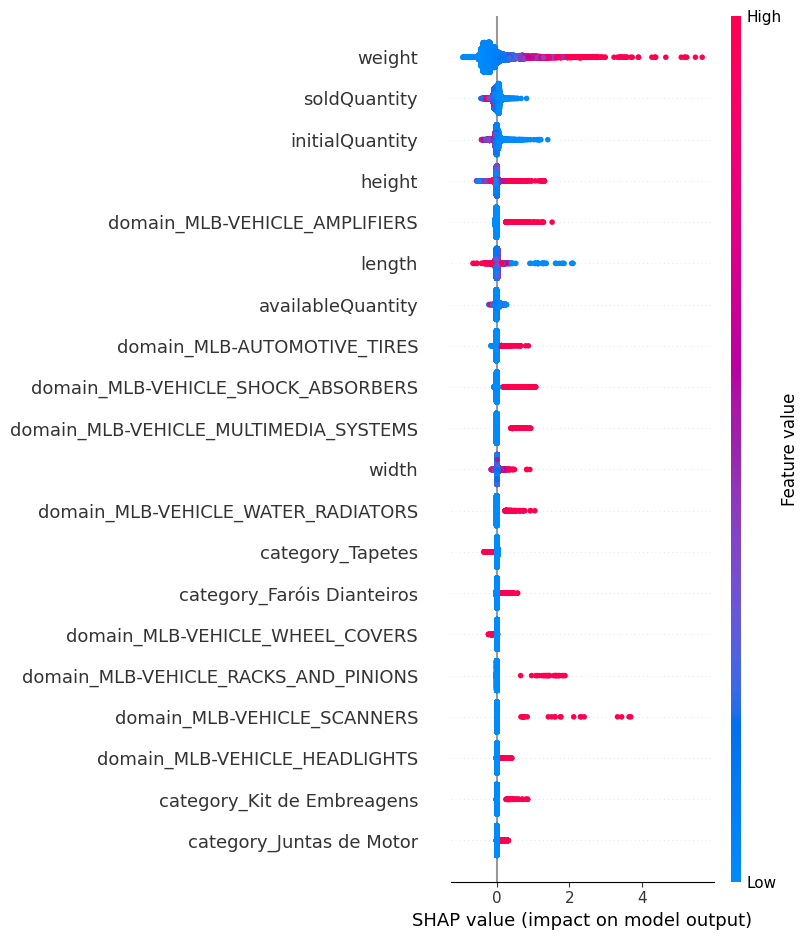

In [ ]:
import shap

# Supondo que você já tenha treinado seu modelo (LightGBM, XGBoost, Random Forest)
# Exemplo para XGBoost
explainer = shap.TreeExplainer(lightgbm)
shap_values = explainer.shap_values(X_test)

# Visualize um gráfico de summary
shap.summary_plot(shap_values, X_test)


## Feed Forward

In [ ]:
!pip install -q tensorflow keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



def evaluate_simple_feedforward_nn(X_train, X_test, X_val, y_train, y_test, y_val, epochs=100, batch_size=32):
    # Escalona os dados
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    # Modelo feedforward básico: apenas uma camada oculta
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))  # Uma única camada oculta com 32 neurônios
    model.add(Dense(1))  # Camada de saída para regressão

    # Compila o modelo
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    # Callback para early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Treina o modelo
    start_train_time = time.time()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
              callbacks=[early_stopping], verbose=1)
    train_time = time.time() - start_train_time

    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    return test_metrics, validation_metrics, train_time, predict_time


def evaluate_feedforward_tuned(X_train, X_test, X_val, y_train, y_test, y_val, epochs=200, batch_size=32):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    model = Sequential()
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1)

    start_train_time = time.time()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
              callbacks=[early_stopping, lr_scheduler], verbose=1)
    train_time = time.time() - start_train_time

    start_predict_time = time.time()
    y_test_pred = model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = model.predict(X_val)

    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    return test_metrics, validation_metrics, train_time, predict_time


# Exemplo de uso
test_metrics_nn, validation_metrics_nn, train_time, predict_time = evaluate_simple_feedforward_nn(X_train, X_test, X_val, y_train, y_test, y_val, epochs=100, batch_size=32)
#test_metrics_nn, validation_metrics_nn, train_time, predict_time = evaluate_feedforward_tuned(X_train, X_test, X_val, y_train, y_test, y_val, epochs=200, batch_size=32)

print("Test Metrics:", test_metrics_nn)
print("Validation Metrics:", validation_metrics_nn)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")

## SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
gc.collect()


def evaluate_svr(X_train, X_test, X_val, y_train, y_test, y_val):
    # Inicializa o modelo SVR
    svr_model = SVR()

    # Treina o modelo com o GridSearch
    start_train_time = time.time()
    model = svr_model.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    # Resultados
    print("Test Metrics:", test_metrics)
    print("Validation Metrics:", validation_metrics)

    return test_metrics, validation_metrics, train_time, predict_time


def evaluate_svr_with_grid(X_train, X_test, X_val, y_train, y_test, y_val):
    # Definindo os parâmetros para o GridSearch
    param_grid = {
        'C': [1],        # Regularização
        'epsilon': [0.2], # Margem de erro
        'kernel': ['linear'], # Tipos de kernel
        'tol': [1e-2],
        'max_iter': [30000]
    }

    # Inicializa o modelo SVR
    svr_model = SVR()

    # Configura o GridSearchCV
    grid_search = GridSearchCV(svr_model, param_grid, cv=3, scoring='r2', n_jobs=-1)

    # Treina o modelo com o GridSearch
    start_train_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    # Obtém o melhor modelo e hiperparâmetros
    best_svr_model = grid_search.best_estimator_

    # Faz previsões
    start_predict_time = time.time()
    y_test_pred = best_svr_model.predict(X_test)
    predict_time = time.time() - start_predict_time
    y_val_pred = best_svr_model.predict(X_val)

    # Calcula as métricas para o conjunto de teste
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    # Calcula as métricas para o conjunto de validação
    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    # Resultados
    print("Best Parameters:", grid_search.best_params_)
    return test_metrics, validation_metrics, train_time, predict_time

# Exemplo de uso
#test_metrics_svr, validation_metrics_svr, train_time, predict_time = evaluate_svr(X_train, X_test, X_val, y_train, y_test, y_val)
test_metrics_svr, validation_metrics_svr, train_time, predict_time = evaluate_svr_with_grid(X_train, X_test, X_val, y_train, y_test, y_val)

print("Test metrics", test_metrics_svr)
print("Validation metrics", validation_metrics_svr)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")

## LSTM

In [ ]:
import numpy as np

import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
gc.collect()

def lstm_with_grid(X_train, X_test, X_val, y_train, y_test, y_val):
    """
    Implementação do LSTM com hiperparâmetros pré-definidos.
    """
    # Parâmetros a serem ajustados (aqui manualmente)
    lstm_units = 64
    dropout_rate = 0.2
    batch_size = 32
    epochs = 20

    # Construindo o modelo LSTM
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1)  # Regressão com uma saída
    ])

    # Compilando o modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Treinando o
    start_train_time = time.time()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    train_time = time.time() - start_train_time

    # Fazendo previsões
    start_predict_time = time.time()
    y_test_pred = model.predict(X_test).flatten()
    predict_time = time.time() - start_predict_time
    y_val_pred = model.predict(X_val).flatten()

    # Calculando métricas
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    return test_metrics, validation_metrics, train_time, predict_time


def lstm_basic(X_train, X_test, X_val, y_train, y_test, y_val):
    """
    Implementação básica do LSTM sem ajuste de hiperparâmetros.
    """
    # Definindo o modelo
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)  # Saída
    ])

    # Compilando o modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Treinando o modelo
    start_train_time = time.time()
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    train_time = time.time() - start_train_time

    # Fazendo previsões
    start_predict_time = time.time()
    y_test_pred = model.predict(X_test).flatten()
    predict_time = time.time() - start_predict_time
    y_val_pred = model.predict(X_val).flatten()

    # Calculando métricas
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'R²': r2_score(y_test, y_test_pred)
    }

    validation_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': mean_squared_error(y_val, y_val_pred, squared=False),
        'R²': r2_score(y_val, y_val_pred)
    }

    return test_metrics, validation_metrics, train_time, predict_time





# Adicionando uma dimensão extra para adequar os dados ao LSTM
X_train_lstm = np.expand_dims(X_train.values, axis=1)  # (samples, 1, features)
X_val_lstm = np.expand_dims(X_val.values, axis=1)      # (samples, 1, features)
X_test_lstm = np.expand_dims(X_test.values, axis=1)    # (samples, 1, features)
X_train_lstm = np.array(X_train_lstm, dtype=np.float32)
X_val_lstm = np.array(X_val_lstm, dtype=np.float32)
X_test_lstm = np.array(X_test_lstm, dtype=np.float32)


# Certifique-se de que y_train, y_val e y_test permaneçam como vetores unidimensionais
y_train_lstm = y_train.values
y_val_lstm = y_val.values
y_test_lstm = y_test.values
y_train_lstm = np.array(y_train_lstm, dtype=np.float32)
y_val_lstm = np.array(y_val_lstm, dtype=np.float32)
y_test_lstm = np.array(y_test_lstm, dtype=np.float32)

# Uso das funções
test_metrics_lstm, validation_metrics_lstm, train_time, predict_time = lstm_with_grid(X_train_lstm, X_test_lstm, X_val_lstm, y_train_lstm, y_test_lstm, y_val_lstm)
#test_metrics_lstm, validation_metrics_lstm, train_time, predict_time = lstm_basic(X_train_lstm, X_test_lstm, X_val_lstm, y_train_lstm, y_test_lstm, y_val_lstm)

print("Test Metrics LSTM:", test_metrics_lstm)
print("Validation Metrics LSTM:", validation_metrics_lstm)
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")

## Avaliação

In [1]:
def gather_metrics(models_metrics):
    """
    Gather metrics from multiple models and create a DataFrame.

    Args:
        models_metrics: Dictionary containing metrics for each model.

    Returns:
        metrics_df: DataFrame containing metrics for each model.
    """
    # Initialize an empty dictionary to hold the metrics
    metrics = {
        'Model': [],
        'MAE (Test)': [],
        'MSE (Test)': [],
        'RMSE (Test)': [],
        'R² (Test)': [],
        'MAE (Validation)': [],
        'MSE (Validation)': [],
        'RMSE (Validation)': [],
        'R² (Validation)': []
    }

    # Iterate over each model in the dictionary
    for model_name, metrics_dict in models_metrics.items():
        metrics['Model'].append(model_name)
        # Extracting test metrics
        metrics['MAE (Test)'].append(metrics_dict['Test']['MAE'])
        metrics['MSE (Test)'].append(metrics_dict['Test']['MSE'])
        metrics['RMSE (Test)'].append(metrics_dict['Test']['RMSE'])
        metrics['R² (Test)'].append(metrics_dict['Test']['R²'])
        # Extracting validation metrics
        metrics['MAE (Validation)'].append(metrics_dict['Validation']['MAE'])
        metrics['MSE (Validation)'].append(metrics_dict['Validation']['MSE'])
        metrics['RMSE (Validation)'].append(metrics_dict['Validation']['RMSE'])
        metrics['R² (Validation)'].append(metrics_dict['Validation']['R²'])

    # Create a DataFrame
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

def plot_metrics(metrics_df):
    """
    Plot metrics from the DataFrame.

    Args:
        metrics_df: DataFrame containing metrics for each model.
    """
    metrics_test = ['MAE (Test)', 'MSE (Test)', 'RMSE (Test)', 'R² (Test)']
    metrics_validation = ['MAE (Validation)', 'MSE (Validation)', 'RMSE (Validation)', 'R² (Validation)']

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Create bar plots for each test metric
    for i, metric in enumerate(metrics_test):
        ax = axs[i // 2, i % 2]
        ax.bar(metrics_df['Model'], metrics_df[metric], color='royalblue')
        ax.set_title(metric)
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


models_metrics = {
    'Linear Regression': {
        'Test': test_metrics_linear_regression,
        'Validation': validation_metrics_linear_regression
    },
    'Lasso': {
        'Test': test_metrics_lasso,
        'Validation': validation_metrics_lasso
    },
    'Ridge': {
        'Test': test_metrics_ridge,
        'Validation': validation_metrics_ridge
    },
    'Random Forest': {
        'Test': test_metrics_random_forest,
        'Validation': validation_metrics_random_forest
    },
    'Light GBM': {
        'Test': test_metrics_lightgbm,
        'Validation': validation_metrics_lightgbm
    },
    'XGBoost': {
        'Test': test_metrics_xgboost,
        'Validation': validation_metrics_xgboost
    },
    'Feed Forward': {
        'Test': test_metrics_nn,
        'Validation': validation_metrics_nn
    },

}

# Gather metrics into a DataFrame
metrics_df = gather_metrics(models_metrics)

# Display the DataFrame
display(metrics_df)

# Plot the metrics
plot_metrics(metrics_df)

NameError: name 'test_metrics_linear_regression' is not defined

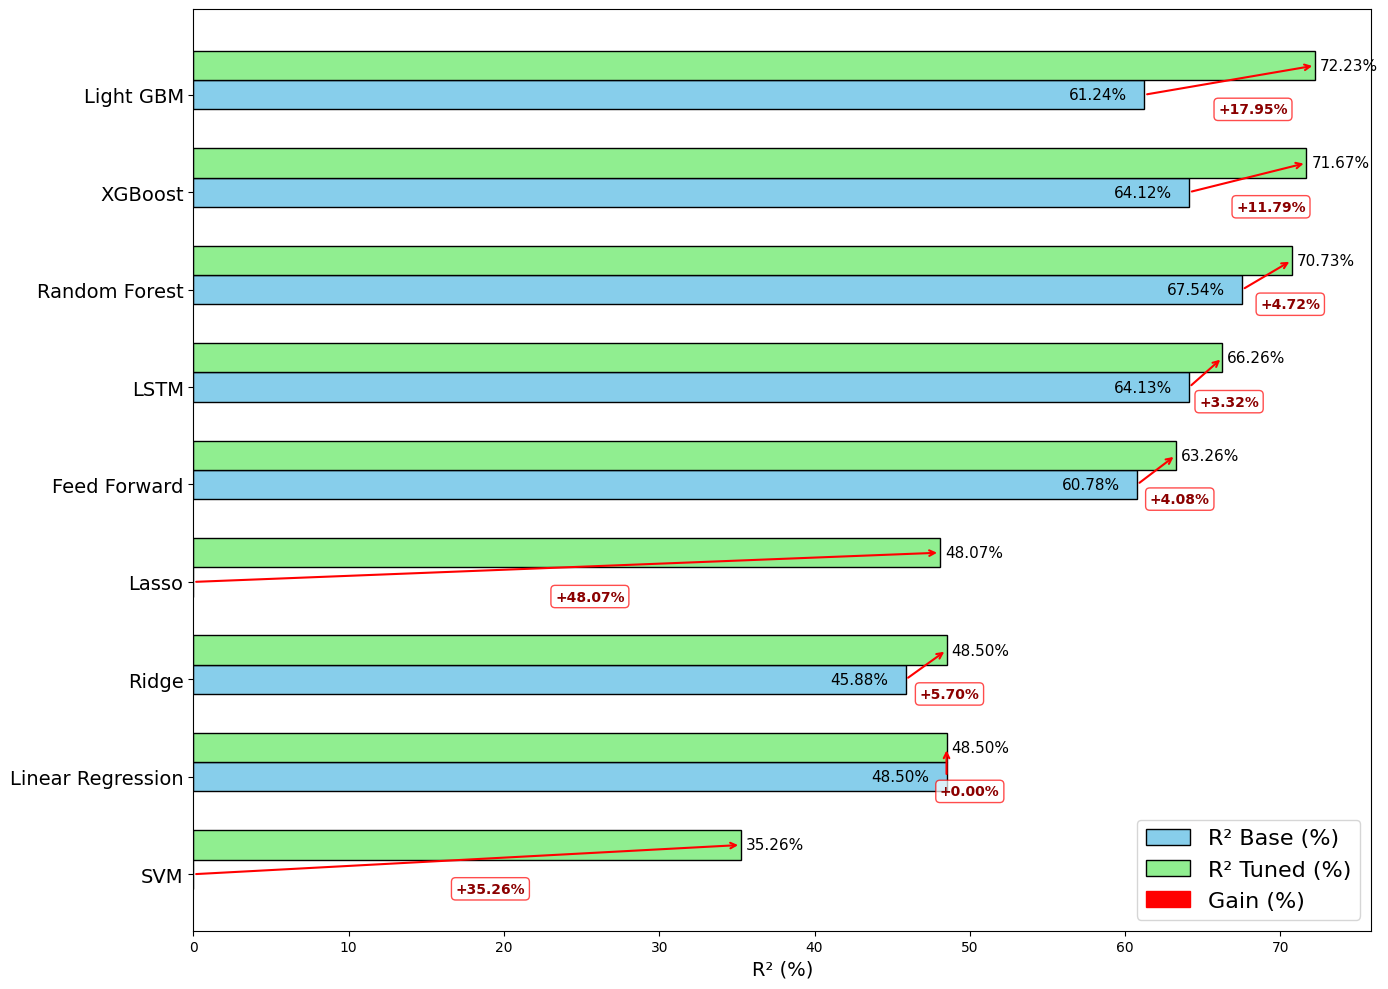

In [9]:
# Importando bibliotecas necessárias
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Criando os dados
data = {
    "Modelo": [
        "SVM", "Linear Regression", "Ridge",
        "Lasso", "Feed Forward", "LSTM", "Random Forest", "XGBoost", "Light GBM"
    ],
    "R2 Base (%)": [0.00, 48.50,  45.88, 0.00, 60.78, 64.13, 67.54, 64.12, 61.24],
    "R2 Refinado (%)": [35.26, 48.50, 48.50, 48.07, 63.26, 66.26, 70.73, 71.67, 72.23],
    "Ganho (%)": [35.26, 0.00, 5.70, 48.07, 4.08, 3.32, 4.72, 11.79, 17.95]
}

# Criando o DataFrame
df = pd.DataFrame(data)

# Configurando o tamanho do gráfico
plt.figure(figsize=(14, 10))
bar_width = 0.3  # Altura das barras

# Gráfico de barras horizontais para R² Base e R² Refinado
base_bars = plt.barh(
    df["Modelo"], df["R2 Base (%)"], height=bar_width, label="R² Base (%)", color="skyblue", edgecolor="black"
)
refined_bars = plt.barh(
    [p + bar_width for p in range(len(df))],
    df["R2 Refinado (%)"],
    height=bar_width,
    label="R² Tuned (%)",
    color="lightgreen",
    edgecolor="black"
)

# Adicionando setas diagonais, valores de R² e valores de ganho
for i in range(len(df)):
    base = df["R2 Base (%)"][i]
    refinado = df["R2 Refinado (%)"][i]
    ganho = df["Ganho (%)"][i]

    # Coordenadas para setas diagonais
    x_start = base
    x_end = refinado
    y_start = i
    y_end = i + bar_width

    # Seta diagonal entre as barras
    plt.annotate(
        "",
        xy=(x_end, y_end),
        xytext=(x_start, y_start),
        arrowprops=dict(arrowstyle="->", color="red", lw=1.5)
    )

    # Valor de ganho ao lado da seta
    plt.text(
        (x_start + x_end) / 2 + 1.5,  # Posição intermediária no eixo X
        (y_start + y_end) / 2 - 0.3,  # Posição intermediária no eixo Y
        f"+{ganho:.2f}%",  # Texto
        ha="center",  # Alinhamento horizontal
        va="center",  # Alinhamento vertical
        fontsize=10,
        color="darkred",
        weight="bold",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white", alpha=0.7)  # Fundo destacado
    )

    # Adicionando valores de R² ao lado das barras
    if base != 0:
      plt.text(base - 3, y_start, f"{base:.2f}%", ha="center", va="center", color="black", fontsize=11)
    plt.text(refinado + 2.2, y_end, f"{refinado:.2f}%", ha="center", va="center", color="black", fontsize=11)

# Aumentando o tamanho da fonte dos nomes dos modelos no eixo Y
plt.yticks(fontsize=14)  # Altere o valor de 'fontsize' conforme necessário para aumentar o tamanho

# Adicionando rótulos e título
plt.xlabel("R² (%)", fontsize=14)
#plt.title("Comparação de R² Base e Refinado por Modelo (com Ganho %)", fontsize=16)
plt.legend(title="Legenda:", fontsize=12)
red_patch = mpatches.Patch(color='red', label='Gain (%)')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(red_patch)
plt.legend(handles=handles, loc="lower right", fontsize=16)

# Ajustando o layout
plt.tight_layout()
plt.show()


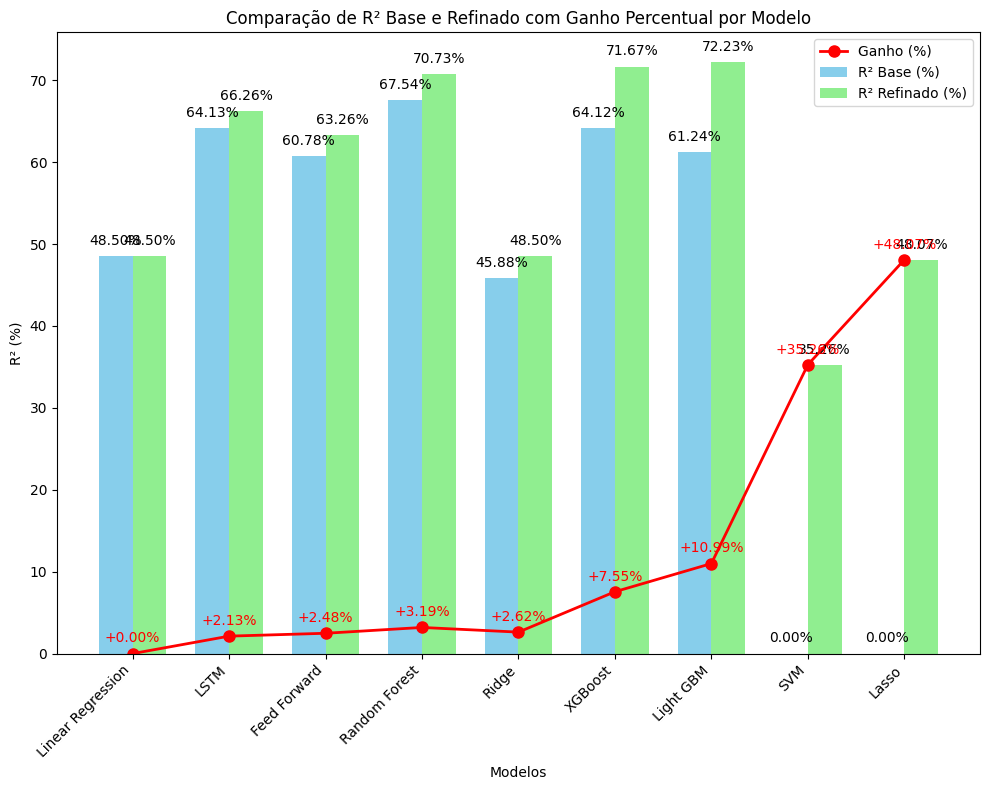

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Dados
modelos = ['Linear Regression', 'LSTM', 'Feed Forward', 'Random Forest', 'Ridge',
           'XGBoost', 'Light GBM', 'SVM', 'Lasso']
r2_base = [48.50, 64.13, 60.78, 67.54, 45.88, 64.12, 61.24, 0.00, 0.00]
r2_refinado = [48.50, 66.26, 63.26, 70.73, 48.50, 71.67, 72.23, 35.26, 48.07]
ganho_percentual = np.array(r2_refinado) - np.array(r2_base)

# Criação do gráfico de barras agrupadas
bar_width = 0.35
index = np.arange(len(modelos))

fig, ax = plt.subplots(figsize=(10, 8))

# Barras para R² Base e R² Refinado
bars_base = ax.bar(index - bar_width / 2, r2_base, bar_width, label='R² Base (%)', color='skyblue')
bars_refinado = ax.bar(index + bar_width / 2, r2_refinado, bar_width, label='R² Refinado (%)', color='lightgreen')

# Plotando a linha de tendência para o ganho percentual
ax.plot(index, ganho_percentual, label='Ganho (%)', color='red', marker='o', linestyle='-', linewidth=2, markersize=8)

# Adicionando os valores de R² e ganho percentual
for i in range(len(modelos)):
    ax.text(index[i] - bar_width / 2, r2_base[i] + 1, f'{r2_base[i]:.2f}%', ha='center', va='bottom', color='black')
    ax.text(index[i] + bar_width / 2, r2_refinado[i] + 1, f'{r2_refinado[i]:.2f}%', ha='center', va='bottom', color='black')
    ax.text(index[i], ganho_percentual[i] + 1, f'+{ganho_percentual[i]:.2f}%', ha='center', va='bottom', color='red')

# Ajustando o layout
ax.set_xlabel('Modelos')
ax.set_ylabel('R² (%)')
ax.set_title('Comparação de R² Base e Refinado com Ganho Percentual por Modelo')
ax.set_xticks(index)
ax.set_xticklabels(modelos, rotation=45, ha='right')
ax.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()


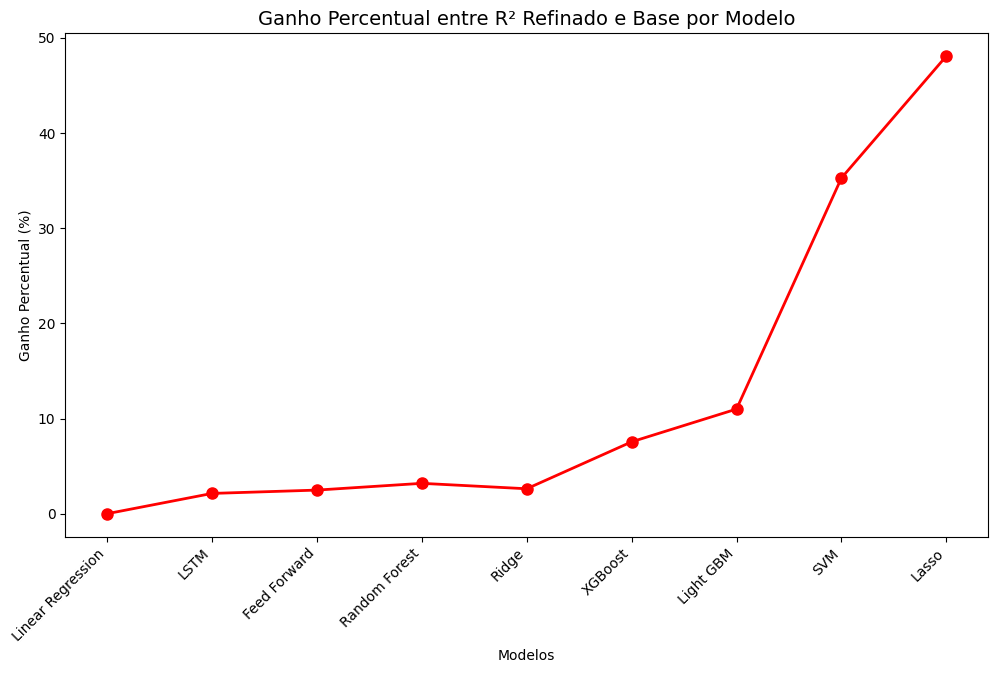

In [11]:
import matplotlib.pyplot as plt

# Dados
modelos = ['Linear Regression', 'LSTM', 'Feed Forward', 'Random Forest', 'Ridge',
           'XGBoost', 'Light GBM', 'SVM', 'Lasso']
r2_base = [48.50, 64.13, 60.78, 67.54, 45.88, 64.12, 61.24, 0.00, 0.00]
r2_refinado = [48.50, 66.26, 63.26, 70.73, 48.50, 71.67, 72.23, 35.26, 48.07]
ganho_percentual = [r2_refinado[i] - r2_base[i] for i in range(len(r2_base))]

# Criando o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(modelos, ganho_percentual, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)

# Adicionando título e rótulos
plt.title('Ganho Percentual entre R² Refinado e Base por Modelo', fontsize=14)
plt.xlabel('Modelos')
plt.ylabel('Ganho Percentual (%)')

# Exibindo o gráfico
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()
